In [1]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from jax import random
from scipy import stats, integrate
from numpyro.diagnostics import hpdi

from hbmep.model import BaseModel
from hbmep import functional as F
from hbmep.util import site

from hbmep.notebooks.rat.util import annotate_heatmap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
ignore_warnings = np.errstate(divide='ignore',invalid='ignore')

HOME = os.getenv("HOME")
EXPERIMENT = "lcirc" # lcirc, csmalar

MODEL_DIR = f"{HOME}/reports/hbmep/notebooks/rat/lognhb/nhb__4000w_1000s_4c_1t_20d_95a_tm/old_{EXPERIMENT}/rectified_logistic"
INFERENCE_FILE = os.path.join(MODEL_DIR, "inference.pkl")
MODEL_FILE = os.path.join(MODEL_DIR, "model.pkl")
EXPERIMENT_TOML_MAP = {"lcirc": "L_CIRC", "lshie": "L_SHIE", "csmalar": "C_SMA_LAR"}
TOML_PATH = f"{HOME}/repos/rat-mapping-paper/configs/{EXPERIMENT_TOML_MAP[EXPERIMENT]}.toml"

MAX_INTENSITY = 9 # 2 ** 9 = 512
NUM_POINTS = 200 # reduce if ram overflows


/home/vishu/repos/refactor/hbmep/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
src = INFERENCE_FILE
with open(src, "rb") as f: df, encoder, posterior, _ = pickle.load(f)

src = MODEL_FILE
with open(src, "rb") as f: model, = pickle.load(f)

subjects = sorted(df['participant'].unique())
subjects_inverse = encoder['participant'].inverse_transform(subjects)
subjects_inverse

positions = sorted(df['compound_position'].unique())
positions_inverse = encoder['compound_position'].inverse_transform(positions)
positions_inverse

a = posterior[site.a]
a.shape

labels = positions_inverse


array(['amap01', 'amap02', 'amap03', 'amap04', 'amap05', 'amap06',
       'amap07', 'amap08'], dtype=object)

array(['-C6LC', '-C6LE', '-C6LN', '-C6LNE', '-C6LNW', '-C6LS', '-C6LSE',
       '-C6LSW', '-C6LW', 'C6LE-C6LC', 'C6LE-C6LW', 'C6LN-C6LC',
       'C6LNE-C6LC', 'C6LNE-C6LSW', 'C6LNW-C6LC', 'C6LS-C6LC',
       'C6LS-C6LN', 'C6LSE-C6LC', 'C6LSE-C6LNW', 'C6LSW-C6LC',
       'C6LW-C6LC'], dtype=object)

(4000, 8, 21, 6)

In [3]:
from hbmep.util import generate_response_colors
colors = generate_response_colors(21, "viridis")


In [4]:
a_mean = a.mean(axis=0)
a_mean.shape


(8, 21, 6)

In [5]:
vertices = list(range(9))
labels[vertices]

diam = [pos_idx for pos_idx, pos in enumerate(positions_inverse) if pos.split("-")[0] != "" and pos[-1] != "C"]
labels[diam]

radii = [pos_idx for pos_idx, pos in enumerate(positions_inverse) if pos not in labels[vertices].tolist() + labels[diam].tolist()]
labels[radii]


array(['-C6LC', '-C6LE', '-C6LN', '-C6LNE', '-C6LNW', '-C6LS', '-C6LSE',
       '-C6LSW', '-C6LW'], dtype=object)

array(['C6LE-C6LW', 'C6LNE-C6LSW', 'C6LS-C6LN', 'C6LSE-C6LNW'],
      dtype=object)

array(['C6LE-C6LC', 'C6LN-C6LC', 'C6LNE-C6LC', 'C6LNW-C6LC', 'C6LS-C6LC',
       'C6LSE-C6LC', 'C6LSW-C6LC', 'C6LW-C6LC'], dtype=object)

In [6]:
a.shape

(4000, 8, 21, 6)

ValueError: Per-column arrays must each be 1-dimensional

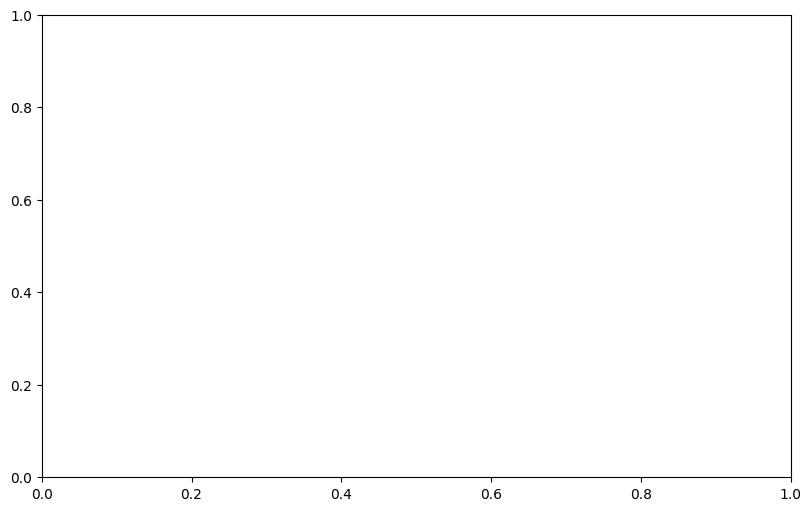

In [7]:
subset = diam.copy()

arr = a_mean[:, subset, ...]
arr.shape

nr, nc = arr.shape[-1] + 1, 1
nr, nc = 1, 1
fig, axes = plt.subplots(nr, nc, figsize=(8 * nc, 5 * nr), constrained_layout=True, squeeze=False)
for r in range(model.num_response):
    for label_idx, label in enumerate(labels[subset]):
    y = arr[:, label_idx]
    x = np.arange(y.shape[0])
    sns.scatterplot(x=x, y=y, ax=ax, color=colors[subset][label_idx], label=label)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show();
# counter = 0
# for subject_idx, subject in zip(subjects, subjects_inverse):
#     ax = axes[counter // nc, counter % nc]
    

In [ ]:
a.mean(axis=0)[]

(4000, 8, 8, 6)

In [13]:
test = stats.wilcoxon(diff, axis=0)
pvalue = test.pvalue
pvalue = mask_upper(pvalue)
pvalue.shape

_test = stats.ttest_1samp(diff, popmean=0)
statistic = _test.statistic
statistic = mask_upper(statistic)
statistic.shape

deg = _test.df
deg = mask_upper(deg)
deg.shape


(8, 8)

(8, 8)

(8, 8)

/tmp/ipykernel_1623720/3619355201.py:9: RuntimeWarning: invalid value encountered in cast
  annotate_heatmap(ax, pvalue, deg.astype(int), 0, 1, **deg_annot_kws)


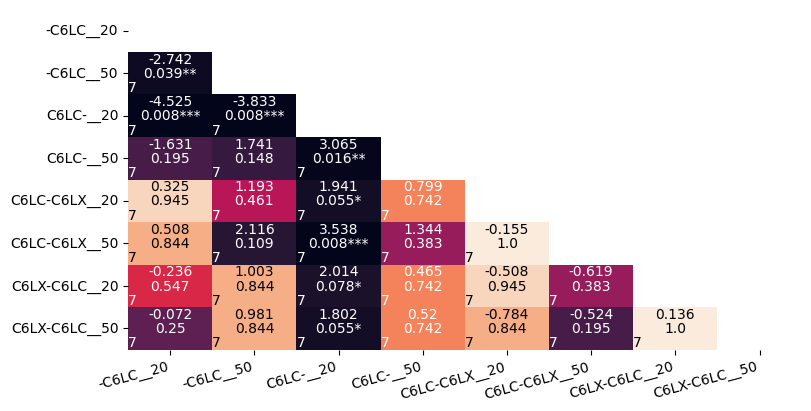

In [14]:
fig, axes = plt.subplots(1, 1, constrained_layout=True, squeeze=False, figsize=(8, 4))
ax = axes[0, 0]
sns.heatmap(pvalue, annot=False, ax=ax, cbar=False)

# Annotate
pvalue_annot_kws = {"ha": 'center', "va": 'center'}
annotate_heatmap(ax, pvalue,  np.round(pvalue, 3), 0.5, 0.5, star=True, star_arr=pvalue, **pvalue_annot_kws)
deg_annot_kws = {"ha": 'left', "va": 'bottom'}
annotate_heatmap(ax, pvalue, deg.astype(int), 0, 1, **deg_annot_kws)
statistic_annot_kws = {"ha": 'center', "va": 'top'}
annotate_heatmap(ax, pvalue, np.round(statistic, 3), 0.5, 0, **statistic_annot_kws)
ax.set_xticklabels(labels=labels, rotation=15, ha="right");
ax.set_yticklabels(labels=labels, rotation=0);


In [11]:
auc.shape

(4000, 8, 4, 2)

In [20]:
t = (auc[..., 2, 1] - auc[..., 0, 1]).nanmean(axis=0)
t.shape

stats.wilcoxon(t).pvalue

stats.ttest_1samp(t, popmean=0).statistic


(8,)

0.015625

2.1372135629649045

In [15]:
positions_inverse
charges_inverse

['-C6LC', 'C6LC-', 'C6LC-C6LX', 'C6LX-C6LC']

['20-0-80-25', '50-0-50-100']

In [14]:
positions_inverse

['-C6LC', 'C6LC-', 'C6LC-C6LX', 'C6LX-C6LC']

In [ ]:
auckkkkkk